In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install jittor


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import jittor as jt
from jittor.dataset import VarDataset, DataLoader

jt.flags.use_cuda = 1

def read_mnist_images(filename):
    with open(filename, 'rb') as f:

        magic_number = int.from_bytes(f.read(4), byteorder='big')
        num_images = int.from_bytes(f.read(4), byteorder='big')
        num_rows = int.from_bytes(f.read(4), byteorder='big')
        num_cols = int.from_bytes(f.read(4), byteorder='big')

        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        return images

def read_mnist_labels(filename):
    with open(filename, 'rb') as f:

        magic_number = int.from_bytes(f.read(4), byteorder='big')
        num_labels = int.from_bytes(f.read(4), byteorder='big')

        labels = np.fromfile(f, dtype=np.uint8)
        return labels

# folder = "/content/drive/MyDrive"
# train_images = read_mnist_images(folder+'/mnist/train-images.idx3-ubyte')
# train_labels = read_mnist_labels(folder+'/mnist/train-labels.idx1-ubyte')
# test_images = read_mnist_images(folder+'/mnist/t10k-images.idx3-ubyte')
# test_labels = read_mnist_labels(folder+'/mnist/t10k-labels.idx1-ubyte')

train_images = read_mnist_images('./mnist/train-images.idx3-ubyte')
train_labels = read_mnist_labels('./mnist/train-labels.idx1-ubyte')
test_images = read_mnist_images('./mnist/t10k-images.idx3-ubyte')
test_labels = read_mnist_labels('./mnist/t10k-labels.idx1-ubyte')


In [3]:
import scipy.ndimage as ndimage

def gaussian_noise(images, std_dev=10):
    '''
    Generate Gaussian white noise.
    Args:
        images: a numpy 2darray (28*28)
        std_dev: standard deviation
    ''' 
    noise = np.random.normal(loc=0, scale=std_dev, size=images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0, 255).astype(int)

    return noisy_images

def image_shift(inputs):
    '''
    Shift the image.
    Args:
        inputs: a numpy 2darray (28*28)
    ''' 
    shift1 = np.random.randint(-7, 8)
    shift2 = np.random.randint(-7, 8)
    shifted_image = ndimage.shift(inputs, [shift1,shift2], mode='constant', cval=0.0)

    return shifted_image


In [4]:
# Partition
count = np.zeros(5)
mask = []   
for i in range(train_images.shape[0]):
    if train_labels[i] <= 4:
        if i % 10 == 0:
            mask.append(True)
            count[train_labels[i]] += 1
        else:
            mask.append(False)
    else:
        mask.append(True)
train_images = train_images[mask]
train_labels = train_labels[mask]

print("train_images.shape before augmentation:  ", train_images.shape)  # (32423, 28, 28)

# Data Augmentation
aug = np.zeros([1,28,28])
aug_label = np.zeros(1)

for i in range(train_images.shape[0]):
    if i%100 == 0:
        
        if aug.shape[0] > 1:
            train_images = np.concatenate((train_images, aug[1:]), axis=0)
        aug = np.zeros([1,28,28])
        # print(i)
    if train_labels[i] <= 4:
        
        aug_label = np.append(aug_label, np.repeat(train_labels[i],9))
        for j in range(3):
            
            added_image = gaussian_noise(train_images[i])
            aug = np.concatenate((aug, np.expand_dims(added_image, axis=0)), axis=0)

            added_image = image_shift(train_images[i])
            aug = np.concatenate((aug, np.expand_dims(added_image, axis=0)), axis=0)

            added_image = gaussian_noise(added_image)
            aug = np.concatenate((aug, np.expand_dims(added_image, axis=0)), axis=0)
if aug.shape[0] > 1:
            train_images = np.concatenate((train_images, aug[1:]), axis=0)
train_labels = np.append(train_labels, aug_label[1:])

print("train_images.shape after augmentation:  ", train_images.shape)
print("train_labels.shape after augmentation:  ", train_labels.shape)


train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

batch_size = 128  

train_images_var = jt.array(train_images)
train_labels_var = jt.array(train_labels)
train_dataset = VarDataset(train_images_var, train_labels_var)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_images_var = jt.array(test_images)
test_labels_var = jt.array(test_labels)
test_dataset = VarDataset(test_images_var, test_labels_var)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


train_images.shape before augmentation:   (32423, 28, 28)
train_images.shape after augmentation:   (59594, 28, 28)
train_labels.shape after augmentation:   (59594,)


In [13]:
from jittor import nn, Module

class RNNmodel(Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim=10):
        super(RNNmodel, self).__init__()
        # self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=False, nonlinearity='tanh', bidirectional=False, dropout=0)
        self.fc = nn.Linear(hidden_size, output_dim)
        # self.fc = nn.Linear(2*hidden_size, output_dim)


    def execute(self, input):
        
        h_0 = jt.zeros(self.num_layers, batch_size, self.hidden_size)

        # h_0 = jt.zeros(2*self.num_layers, batch_size, self.hidden_size)
        
        x, h_n = self.rnn(input, h_0)

        # print("x(output of rnn).shape: ",x.shape)
        
        x = x[-1,:,:]

        # print("x.shape: ",x.shape)
        x = self.fc(x)
        # print("x.shape: ",x.shape)
        # print("execution finished\n")
        return x

input_size = 28       # The number of expected features in the input `x`
hidden_size = 200     # The number of features in the hidden state `h`
num_layers = 4        # Number of recurrent layers. E.g., setting ``num_layers=2`` would mean stacking two RNNs together to form a `stacked RNN` 
output_dim = 10

model = RNNmodel(input_size, hidden_size, num_layers, output_dim)
loss_function = nn.CrossEntropyLoss()

learning_rate = 0.05
momentum = 0
weight_decay = 0
optimizer = nn.SGD(model.parameters(), learning_rate, momentum, weight_decay)

# optimizer = nn.Adam(model.parameters(), learning_rate)

def train(model, train_loader, loss_function, optimizer, epoch):
    model.train()
    train_losses = []

    for batch_index, (inputs, targets) in enumerate(train_loader):

        # outputs = model(inputs)
        outputs = model(jt.transpose(inputs,0,1))

        # print("inputs: ",inputs.shape)
        # print("outputs: ",outputs.shape)
        # # print(np.argmax(outputs.data, axis = 1))
        # print("targets: ",targets.shape, "\n")

        loss = loss_function(outputs, targets)
        optimizer.step(loss)

        train_losses.append(loss)

        if batch_index % 500 == 0:   
            print(f"Train epoch {epoch+1}, batch {batch_index}\tLoss: ", "%.5f" % loss)
    return train_losses

def test(model, val_loader, epoch):
    model.eval()
    total_correct = 0
    total_samples = 0
    for batch_index, (inputs, targets) in enumerate(val_loader):
        # outputs = model(inputs)
        outputs = model(jt.transpose(inputs,0,1))

        prediction = np.argmax(outputs.data, axis=1)

        # print("inputs: ",inputs.shape)
        # print("outputs: ",outputs.shape)
        # # print(outputs)
        # print("prediction: ", prediction)
        # print("targets: ",targets.shape, targets, "\n")

        correct = np.sum(targets.data==prediction)
        batch_size = inputs.shape[0]
        
        total_correct += correct
        total_samples += batch_size
        
    test_acc = total_correct / total_samples
    print (f'Epoch {epoch+1}\tTest acc is {test_acc}\n')              
    return test_acc


epochs = 20
train_losses = []
test_acc = []
for epoch in range(epochs):
    loss = train(model, train_loader, loss_function, optimizer, epoch)
    train_losses += loss
    acc = test(model, test_loader, epoch)
    test_acc.append(acc)

Train epoch 1, batch 0	Loss:  2.30374
Epoch 1	Test acc is 0.7056

Train epoch 2, batch 0	Loss:  0.52979
Epoch 2	Test acc is 0.8319

Train epoch 3, batch 0	Loss:  0.41407
Epoch 3	Test acc is 0.8436

Train epoch 4, batch 0	Loss:  0.26688
Epoch 4	Test acc is 0.8921

Train epoch 5, batch 0	Loss:  0.20878
Epoch 5	Test acc is 0.9275

Train epoch 6, batch 0	Loss:  0.05969
Epoch 6	Test acc is 0.8959

Train epoch 7, batch 0	Loss:  0.23023
Epoch 7	Test acc is 0.9519

Train epoch 8, batch 0	Loss:  0.07702
Epoch 8	Test acc is 0.9536

Train epoch 9, batch 0	Loss:  0.06972
Epoch 9	Test acc is 0.9477

Train epoch 10, batch 0	Loss:  0.10069
Epoch 10	Test acc is 0.9558

Train epoch 11, batch 0	Loss:  0.09867
Epoch 11	Test acc is 0.9483

Train epoch 12, batch 0	Loss:  0.09419
Epoch 12	Test acc is 0.9625

Train epoch 13, batch 0	Loss:  0.04402
Epoch 13	Test acc is 0.9555

Train epoch 14, batch 0	Loss:  0.06606
Epoch 14	Test acc is 0.9655

Train epoch 15, batch 0	Loss:  0.04815
Epoch 15	Test acc is 0.9613

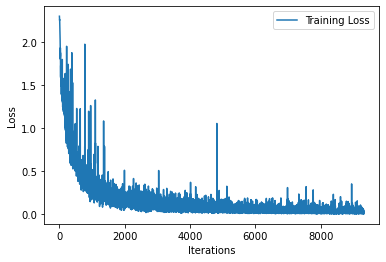

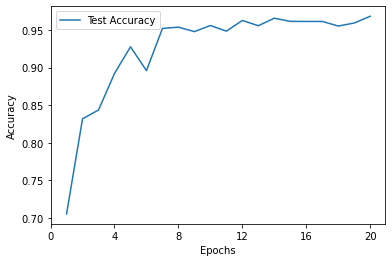

In [14]:
# print(len(train_losses.shape)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"bi_loss_batch{batch_size}_epoch{epochs}_hsize{hidden_size}_nlayers{num_layers}_lr{learning_rate}_m{momentum}_wd{weight_decay}.jpg", dpi=800)
plt.show()

plt.plot(range(1, epochs+1), test_acc, label="Test Accuracy")
plt.xticks([0, 4, 8, 12, 16, 20])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"bi_acc_batch{batch_size}_epoch{epochs}_hsize{hidden_size}_nlayers{num_layers}_lr{learning_rate}_m{momentum}_wd{weight_decay}.jpg", dpi=800)
plt.show()